In [1]:
import ast
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
import random
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.notebook import tqdm

c:\Users\user\anaconda3\envs\test-0602\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 1. Seed 고정
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# 2. 데이터 로드
df = pd.read_csv('../../db/dataset_2023_2025.csv')

In [4]:
# 3. 스케일링
header_str = """
news_id,summary,d_minus_5_date_close,d_minus_5_date_volume,d_minus_5_date_foreign,d_minus_5_date_institution,d_minus_5_date_individual,d_minus_4_date_close,d_minus_4_date_volume,d_minus_4_date_foreign,d_minus_4_date_institution,d_minus_4_date_individual,d_minus_3_date_close,d_minus_3_date_volume,d_minus_3_date_foreign,d_minus_3_date_institution,d_minus_3_date_individual,d_minus_2_date_close,d_minus_2_date_volume,d_minus_2_date_foreign,d_minus_2_date_institution,d_minus_2_date_individual,d_minus_1_date_close,d_minus_1_date_volume,d_minus_1_date_foreign,d_minus_1_date_institution,d_minus_1_date_individual,d_plus_1_date_close,d_plus_2_date_close,d_plus_3_date_close,d_plus_4_date_close,d_plus_5_date_close,fx,bond10y,base_rate,토픽 1,토픽 2,토픽 3,토픽 4,토픽 5,토픽 6,토픽 7,토픽 8,토픽 9,similar_news_id,similar_summary,similar_d_minus_5_date_close,similar_d_minus_5_date_volume,similar_d_minus_5_date_foreign,similar_d_minus_5_date_institution,similar_d_minus_5_date_individual,similar_d_minus_4_date_close,similar_d_minus_4_date_volume,similar_d_minus_4_date_foreign,similar_d_minus_4_date_institution,similar_d_minus_4_date_individual,similar_d_minus_3_date_close,similar_d_minus_3_date_volume,similar_d_minus_3_date_foreign,similar_d_minus_3_date_institution,similar_d_minus_3_date_individual,similar_d_minus_2_date_close,similar_d_minus_2_date_volume,similar_d_minus_2_date_foreign,similar_d_minus_2_date_institution,similar_d_minus_2_date_individual,similar_d_minus_1_date_close,similar_d_minus_1_date_volume,similar_d_minus_1_date_foreign,similar_d_minus_1_date_institution,similar_d_minus_1_date_individual,similar_d_plus_1_date_close,similar_d_plus_2_date_close,similar_d_plus_3_date_close,similar_d_plus_4_date_close,similar_d_plus_5_date_close,similar_fx,similar_bond10y,similar_base_rate,similar_토픽 1,similar_토픽 2,similar_토픽 3,similar_토픽 4,similar_토픽 5,similar_토픽 6,similar_토픽 7,similar_토픽 8,similar_토픽 9,target
"""

header_cols = [col.strip() for col in header_str.strip().split(',')]

ext_a = [col for col in header_cols if col.startswith('d_minus_') or col.startswith('d_plus_') or col.startswith('D_day_') or col in ['fx', 'bond10y', 'base_rate'] or col.startswith('토픽 ')]
ext_b = [col for col in header_cols if col.startswith('similar_d_minus_') or col.startswith('similar_d_plus_') or col.startswith('similar_D_day_') or col in ['similar_fx', 'similar_bond10y', 'similar_base_rate'] or col.startswith('similar_토픽 ')]

group_ext_price_close = [c for c in ext_a if 'date_close' in c]
group_ext_volume = [c for c in ext_a if 'date_volume' in c]
group_ext_foreign = [c for c in ext_a if 'date_foreign' in c]
group_ext_institution = [c for c in ext_a if 'date_institution' in c]
group_ext_individual = [c for c in ext_a if 'date_individual' in c]
group_ext_macro = ['fx', 'bond10y', 'base_rate']
group_ext_topic = [f'토픽 {i}' for i in range(1, 10) if f'토픽 {i}' in ext_a]

group_ext_similar_price_close = [c for c in ext_b if 'date_close' in c]
group_ext_similar_volume = [c for c in ext_b if 'date_volume' in c]
group_ext_similar_foreign = [c for c in ext_b if 'date_foreign' in c]
group_ext_similar_institution = [c for c in ext_b if 'date_institution' in c]
group_ext_similar_individual = [c for c in ext_b if 'date_individual' in c]
group_ext_similar_macro = ['similar_fx', 'similar_bond10y', 'similar_base_rate']
group_ext_similar_topic = [f'similar_토픽 {i}' for i in range(1, 10) if f'similar_토픽 {i}' in ext_b]

ext_a_groups = [
    group_ext_price_close, group_ext_volume, group_ext_foreign,
    group_ext_institution, group_ext_individual,
    group_ext_macro, group_ext_topic
]

ext_b_groups = [
    group_ext_similar_price_close, group_ext_similar_volume, group_ext_similar_foreign,
    group_ext_similar_institution, group_ext_similar_individual,
    group_ext_similar_macro, group_ext_similar_topic
]

scaler_choices_a = [
    StandardScaler(), RobustScaler(), MinMaxScaler(),
    MinMaxScaler(), MinMaxScaler(), StandardScaler(), MinMaxScaler()
]

scaler_choices_b = [
    StandardScaler(), RobustScaler(), MinMaxScaler(),
    MinMaxScaler(), MinMaxScaler(), StandardScaler(), MinMaxScaler()
]

scaler_dict_a = {}
scaler_dict_b = {}

train_idx, val_idx = train_test_split(np.arange(len(df)), test_size=0.2, random_state=42)

extA_scaled_parts = []
for group, scaler in zip(ext_a_groups, scaler_choices_a):
    X_train = df.loc[train_idx, group].replace([np.inf, -np.inf], np.nan).fillna(df[group].mean())
    scaler.fit(X_train)
    X_all = df[group].replace([np.inf, -np.inf], np.nan).fillna(df[group].mean())
    X_scaled = scaler.transform(X_all)
    extA_scaled_parts.append(X_scaled)
    scaler_dict_a[group[0]] = scaler

extB_scaled_parts = []
for group, scaler in zip(ext_b_groups, scaler_choices_b):
    X_train = df.loc[train_idx, group].replace([np.inf, -np.inf], np.nan).fillna(df[group].mean())
    scaler.fit(X_train)
    X_all = df[group].replace([np.inf, -np.inf], np.nan).fillna(df[group].mean())
    X_scaled = scaler.transform(X_all)
    extB_scaled_parts.append(X_scaled)
    scaler_dict_b[group[0]] = scaler

extA_scaled = np.concatenate(extA_scaled_parts, axis=1)
extB_scaled = np.concatenate(extB_scaled_parts, axis=1)

extA_tensor = torch.tensor(extA_scaled, dtype=torch.float32)
extB_tensor = torch.tensor(extB_scaled, dtype=torch.float32)
y_tensor = torch.tensor(df['target'].values, dtype=torch.float32).unsqueeze(1)

print("ext_a / ext_b 그룹별 성격별 스케일링 + tensor 변환까지 최종 완료")

ext_a / ext_b 그룹별 성격별 스케일링 + tensor 변환까지 최종 완료


In [5]:
# 4. 임베딩 생성
model_name = "snunlp/KR-SBERT-V40K-klueNLI-augSTS"
model_emb = SentenceTransformer(model_name)
if torch.cuda.is_available():
    model_emb = model_emb.to("cuda")

print("[임베딩 중] summary/유사 summary 임베딩 생성 중...")
df['embedding'] = model_emb.encode(df['summary'].tolist(), show_progress_bar=True).tolist()
df['similar_embedding'] = model_emb.encode(df['similar_summary'].tolist(), show_progress_bar=True).tolist()

[임베딩 중] summary/유사 summary 임베딩 생성 중...


Batches: 100%|██████████| 1344/1344 [19:10<00:00,  1.17it/s]


In [6]:
tokenizer = model_emb.tokenizer

In [7]:
# 5. 오토인코더 정의 (latent_dim=256)
class EmbeddingAutoencoder(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=256):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512), nn.GELU(), nn.BatchNorm1d(512), nn.Dropout(0.1),
            nn.Linear(512, 384), nn.GELU(), nn.BatchNorm1d(384), nn.Dropout(0.1),
            nn.Linear(384, hidden_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 384), nn.GELU(), nn.BatchNorm1d(384), nn.Dropout(0.1),
            nn.Linear(384, 512), nn.GELU(), nn.BatchNorm1d(512), nn.Dropout(0.1),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

# AE 학습
print("[AE 학습 중]...")
text_emb = df['embedding'].apply(lambda x: np.array(ast.literal_eval(x)) if isinstance(x, str) else x)
X = torch.stack([torch.tensor(e, dtype=torch.float32) for e in text_emb.tolist()])
loader = DataLoader(TensorDataset(X), batch_size=64, shuffle=True)

ae_model = EmbeddingAutoencoder(hidden_dim=256)
optimizer = torch.optim.Adam(ae_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.5)
criterion = nn.MSELoss()

for epoch in range(1, 31):
    ae_model.train()
    epoch_loss = 0
    for batch in loader:
        x_batch = batch[0]
        x_hat, z = ae_model(x_batch)
        loss = criterion(x_hat, x_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item() * x_batch.size(0)
    scheduler.step()
    print(f"AE Epoch {epoch}/30, Loss: {epoch_loss / len(X):.6f}")

[AE 학습 중]...
AE Epoch 1/30, Loss: 0.110500
AE Epoch 2/30, Loss: 0.057536
AE Epoch 3/30, Loss: 0.051610
AE Epoch 4/30, Loss: 0.049034
AE Epoch 5/30, Loss: 0.047281
AE Epoch 6/30, Loss: 0.046127
AE Epoch 7/30, Loss: 0.045263
AE Epoch 8/30, Loss: 0.044702
AE Epoch 9/30, Loss: 0.044229
AE Epoch 10/30, Loss: 0.043861
AE Epoch 11/30, Loss: 0.043490
AE Epoch 12/30, Loss: 0.043235
AE Epoch 13/30, Loss: 0.042994
AE Epoch 14/30, Loss: 0.042732
AE Epoch 15/30, Loss: 0.042476
AE Epoch 16/30, Loss: 0.042403
AE Epoch 17/30, Loss: 0.042271
AE Epoch 18/30, Loss: 0.042166
AE Epoch 19/30, Loss: 0.041941
AE Epoch 20/30, Loss: 0.041889
AE Epoch 21/30, Loss: 0.041819
AE Epoch 22/30, Loss: 0.041746
AE Epoch 23/30, Loss: 0.041583
AE Epoch 24/30, Loss: 0.041511
AE Epoch 25/30, Loss: 0.041481
AE Epoch 26/30, Loss: 0.040425
AE Epoch 27/30, Loss: 0.040388
AE Epoch 28/30, Loss: 0.040389
AE Epoch 29/30, Loss: 0.040297
AE Epoch 30/30, Loss: 0.040308


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimilarityRegressorWithTextCosine(nn.Module):
    def __init__(self, embedding_model, autoencoder_encoder, tokenizer, ext_dim=42, latent_dim=256, alpha=2.0):
        super().__init__()
        self.embedding_model = embedding_model
        self.tokenizer = tokenizer
        self.encoder = autoencoder_encoder
        self.ext_dim = ext_dim
        self.latent_dim = latent_dim
        self.input_dim = latent_dim + ext_dim
        self.alpha = alpha

        self.news_fc = nn.Sequential(
            nn.Linear(self.input_dim, 256), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.2)
        )

    def encode_text(self, text_list):
        with torch.no_grad():
            emb = self.embedding_model.encode(text_list, convert_to_tensor=True)
            emb = emb.to(next(self.encoder.parameters()).device).float()
            reduced = self.encoder(emb)
            return reduced

    def forward(self, summary_list, similar_summary_list, extA, extB):
        # 임베딩 + AE 축소
        zA = self.encode_text(summary_list)
        zB = self.encode_text(similar_summary_list)

        # 외부 피처 스케일링 후 결합
        extA = self.alpha * extA.to(zA.device)
        extB = self.alpha * extB.to(zB.device)

        inputA = torch.cat([zA, extA], dim=1)
        inputB = torch.cat([zB, extB], dim=1)

        # FC 통과
        hA = self.news_fc(inputA)
        hB = self.news_fc(inputB)

        # ✅ 코사인 유사도 계산
        sim = F.cosine_similarity(hA, hB, dim=1)
        return sim


In [9]:
# 7. Dataset 및 DataLoader 정의
class NewsSimilarityDataset(Dataset):
    def __init__(self, df, extA_tensor, extB_tensor, y_tensor, indices):
        self.summary = df["summary"].iloc[indices].tolist()
        self.similar_summary = df["similar_summary"].iloc[indices].tolist()
        self.extA = extA_tensor[indices]
        self.extB = extB_tensor[indices]
        self.y = y_tensor[indices]

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (
            self.summary[idx],
            self.similar_summary[idx],
            self.extA[idx],
            self.extB[idx],
            self.y[idx]
        )

train_dataset = NewsSimilarityDataset(df, extA_tensor, extB_tensor, y_tensor, train_idx)
val_dataset = NewsSimilarityDataset(df, extA_tensor, extB_tensor, y_tensor, val_idx)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [12]:
from tqdm import tqdm

In [13]:
# 8. 학습 loop (Early Stopping 적용)
model = SimilarityRegressorWithTextCosine(
    embedding_model=model_emb,
    autoencoder_encoder=ae_model.encoder,
    tokenizer=model_emb.tokenizer,
    ext_dim=extA_tensor.shape[1],
    latent_dim=256,
    alpha=2.0,
).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

best_val_loss = float('inf')
patience, trigger = 5, 0

for epoch in range(1, 51):
    model.train()
    train_losses = []

    print(f'\nEpoch {epoch}/50 (Patience: {patience - trigger} left)')

    # Train loop (with tqdm)
    for summary, similar_summary, extA, extB, y in tqdm(train_loader, desc=f"Train Epoch {epoch}", leave=False):
        extA, extB, y = extA.to(model.encoder[0].weight.device), extB.to(model.encoder[0].weight.device), y.to(model.encoder[0].weight.device)
        pred = model(summary, similar_summary, extA, extB)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    # Validation loop (with tqdm)
    val_losses = []
    model.eval()
    with torch.no_grad():
        for summary, similar_summary, extA, extB, y in tqdm(val_loader, desc=f"Val Epoch {epoch}", leave=False):
            extA, extB, y = extA.to(model.encoder[0].weight.device), extB.to(model.encoder[0].weight.device), y.to(model.encoder[0].weight.device)
            pred = model(summary, similar_summary, extA, extB)
            loss = loss_fn(pred, y)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    print(f"Epoch {epoch} | Train Loss: {np.mean(train_losses):.4f} | Val Loss: {val_loss:.4f}")

    # Early Stopping 로직
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger = 0
    else:
        trigger += 1
        print(f"No improvement. patience counter: {trigger}/{patience}")
        if trigger >= patience:
            print("Early stopping triggered!")
            break


Epoch 1/50 (Patience: 5 left)


c:\Users\user\anaconda3\envs\test-0602\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Exception ignored in: <function tqdm.__del__ at 0x0000017C505434C0>
Traceback (most recent call last):
  File "c:\Users\user\anaconda3\envs\test-0602\lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\user\anaconda3\envs\test-0602\lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


KeyboardInterrupt: 

In [11]:
# 9. 검증
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for summary, similar_summary, extA, extB, y in val_loader:
        extA, extB, y = extA.to(model.encoder[0].weight.device), extB.to(model.encoder[0].weight.device), y.to(model.encoder[0].weight.device)
        pred = model(summary, similar_summary, extA, extB)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"Validation MSE : {mse:.4f}")
print(f"Validation RMSE: {rmse:.4f}")
print(f"Validation R²  : {r2:.4f}")

Validation MSE : 0.0047
Validation RMSE: 0.0687
Validation R²  : 0.4903


In [45]:
import joblib
import os

# 저장 경로 생성
os.makedirs('C_onnx/scalers_grouped', exist_ok=True)

# extA 스케일러 저장
for group, scaler in zip(ext_a_groups, scaler_choices_a):
    if group:  # 빈 리스트 방지
        group_key = group[0]  # 그룹 내 첫 번째 컬럼명을 키로 사용
        save_path = f'C_onnx/scalers_grouped/extA_{group_key}.pkl'
        joblib.dump(scaler, save_path)
        print(f'✔ Saved extA scaler: {save_path}')

# extB 스케일러 저장
for group, scaler in zip(ext_b_groups, scaler_choices_b):
    if group:
        group_key = group[0]
        save_path = f'C_onnx/scalers_grouped/extB_{group_key}.pkl'
        joblib.dump(scaler, save_path)
        print(f'✔ Saved extB scaler: {save_path}')

✔ Saved extA scaler: C_onnx/scalers_grouped/extA_d_minus_5_date_close.pkl
✔ Saved extA scaler: C_onnx/scalers_grouped/extA_d_minus_5_date_volume.pkl
✔ Saved extA scaler: C_onnx/scalers_grouped/extA_d_minus_5_date_foreign.pkl
✔ Saved extA scaler: C_onnx/scalers_grouped/extA_d_minus_5_date_institution.pkl
✔ Saved extA scaler: C_onnx/scalers_grouped/extA_d_minus_5_date_individual.pkl
✔ Saved extA scaler: C_onnx/scalers_grouped/extA_fx.pkl
✔ Saved extA scaler: C_onnx/scalers_grouped/extA_토픽 1.pkl
✔ Saved extB scaler: C_onnx/scalers_grouped/extB_similar_d_minus_5_date_close.pkl
✔ Saved extB scaler: C_onnx/scalers_grouped/extB_similar_d_minus_5_date_volume.pkl
✔ Saved extB scaler: C_onnx/scalers_grouped/extB_similar_d_minus_5_date_foreign.pkl
✔ Saved extB scaler: C_onnx/scalers_grouped/extB_similar_d_minus_5_date_institution.pkl
✔ Saved extB scaler: C_onnx/scalers_grouped/extB_similar_d_minus_5_date_individual.pkl
✔ Saved extB scaler: C_onnx/scalers_grouped/extB_similar_fx.pkl
✔ Saved extB s

In [27]:
from transformers import AutoTokenizer

# tokenizer는 HuggingFace에서 제공한 경우 디스크에 저장
tokenizer.save_pretrained('./tokenizer_dir')

('./tokenizer_dir/tokenizer_config.json',
 './tokenizer_dir/special_tokens_map.json',
 './tokenizer_dir/vocab.txt',
 './tokenizer_dir/added_tokens.json',
 './tokenizer_dir/tokenizer.json')

In [29]:
!pip install onnx

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 38.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 49.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [30]:
import torch
import torch.onnx
import torch.nn as nn

# ===== (1) 오토인코더 모델 정의 (인코더만 저장) =====
class EmbeddingAutoencoder(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=256):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512), nn.GELU(), nn.BatchNorm1d(512), nn.Dropout(0.1),
            nn.Linear(512, 384), nn.GELU(), nn.BatchNorm1d(384), nn.Dropout(0.1),
            nn.Linear(384, hidden_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 384), nn.GELU(), nn.BatchNorm1d(384), nn.Dropout(0.1),
            nn.Linear(384, 512), nn.GELU(), nn.BatchNorm1d(512), nn.Dropout(0.1),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

# ===== (2) 오토인코더 인코더만 ONNX로 저장 =====
ae_encoder = ae_model.encoder.eval().cpu()

dummy_input_ae = torch.randn(1, 768)  # 텍스트 임베딩 차원
torch.onnx.export(
    ae_encoder,
    dummy_input_ae,
    'ae_encoder.onnx',
    input_names=['embedding'],
    output_names=['latent'],
    opset_version=13,
    dynamic_axes={'embedding': {0: 'batch_size'}, 'latent': {0: 'batch_size'}}
)
print('오토인코더 인코더 ONNX 저장 완료')

오토인코더 인코더 ONNX 저장 완료


In [31]:
# ===== (3) 회귀 모델 구조만 따로 정의 (Text latent + ext 합쳐서 hA, hB → 최종 예측) =====
class SimilarityRegressorOnly(nn.Module):
    def __init__(self, input_dim=256 + 42):  # latent_dim + ext_dim
        super().__init__()
        self.news_fc = nn.Sequential(
            nn.Linear(input_dim, 256), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.2)
        )
        self.regressor = nn.Sequential(
            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, inputA, inputB):
        hA = self.news_fc(inputA)
        hB = self.news_fc(inputB)
        concat = torch.cat([hA, hB], dim=1)
        return self.regressor(concat)

# ===== (4) 학습된 파라미터 반영 및 ONNX 저장 =====
regressor_model = SimilarityRegressorOnly().eval().cpu()
regressor_model.load_state_dict(model.state_dict(), strict=False)

dummy_A = torch.randn(1, 298)  # 256+42
dummy_B = torch.randn(1, 298)

torch.onnx.export(
    regressor_model,
    (dummy_A, dummy_B),
    'regressor_model.onnx',
    input_names=['inputA', 'inputB'],
    output_names=['prediction'],
    opset_version=13,
    dynamic_axes={
        'inputA': {0: 'batch_size'},
        'inputB': {0: 'batch_size'},
        'prediction': {0: 'batch_size'}
    }
)
print('회귀 모델 ONNX 저장 완료')

회귀 모델 ONNX 저장 완료


In [12]:
# 기준 뉴스 하나 선택 (0번째 뉴스)
target_news = df['summary'].iloc[0]
print("[기준 뉴스 요약 내용]")
print(target_news)
print("\n")

# 기준 뉴스와 연결된 비교 뉴스들만 추출
matched_df = df[df['summary'] == target_news].reset_index(drop=True)

# 모델 예측값 생성
model.eval()
with torch.no_grad():
    summaries = matched_df['summary'].tolist()
    similar_summaries = matched_df['similar_summary'].tolist()
    extA_batch = extA_tensor[matched_df.index].to(next(model.parameters()).device)
    extB_batch = extB_tensor[matched_df.index].to(next(model.parameters()).device)

    preds = model(summaries, similar_summaries, extA_batch, extB_batch)
    preds = preds.squeeze().cpu().numpy()

# 정답 값 (target)
true_vals = y_tensor[matched_df.index].squeeze().numpy()

# 결과 DataFrame 구성 및 정렬
matched_df = matched_df.copy()
matched_df['predicted_score'] = preds
matched_df['true_score'] = true_vals
matched_df['abs_error'] = np.abs(preds - true_vals)

matched_df_sorted = matched_df.sort_values(by='predicted_score', ascending=False).reset_index(drop=True)

# 출력
print("[비교 뉴스 예측 유사도 순 정렬]")
for i, row in matched_df_sorted.iterrows():
    print(f"{i+1}. news_id: {row['similar_news_id']}")
    print(f" 예측 유사도: {row['predicted_score']:.4f} | 실제값: {row['true_score']:.4f} | 오차: {row['abs_error']:.4f}")
    print(f" 뉴스 요약: {row['similar_summary'][:300]}...\n")

[기준 뉴스 요약 내용]
23일 정보기술(IT)·투자은행(IB) 업계에 따르면 국내 대표 전자결제사업자인 카카오페이가 SSG닷컴 쓱페이와 G마켓 스마일페이 인수를 위해 신세계이마트 측과 협상을 진행 중인 것으로 알려졌다.


[비교 뉴스 예측 유사도 순 정렬]
1. news_id: 20241230_0302
 예측 유사도: 0.7416 | 실제값: 0.5936 | 오차: 0.1480
 뉴스 요약: 지난 26일 이마트는 공시를 통해 알리익스프레스와 G마켓의 지분 출자를 밝혔는데, 이번 출자를 통해서 알리익스와 G마켓은 물류+온라인에 대한 시너지 발현을 통해 쿠팡이 독주하고 있는 시장을 견제한다는 설명이다....

2. news_id: 20240913_0041
 예측 유사도: 0.6954 | 실제값: 0.6229 | 오차: 0.0725
 뉴스 요약: 카카오뱅크, 일본 S 스미신넷뱅크, 미국 뱅코프 등 세 곳을 비교기업으로 선정한 케이뱅크는 다음달 10~16일 기관 수요예측, 21~22일 일반 청약을 거쳐 다음달 말 상장할 계획이다....

3. news_id: 20240614_0253
 예측 유사도: 0.6928 | 실제값: 0.5782 | 오차: 0.1146
 뉴스 요약: 최근 CJ대한통운은 신세계 그룹과 물류 협력을 추진하기로 하면서 G마켓과 SSG.com의 스마일 배송 물량은 월 250만건, 새벽 배송·쓱배송 물량은 200만건 수준으로 알려졌으며 신세계 그룹은 이마트 산지 농산물 매입 등도 CJ대한 통운에 위탁하는 방안을 협의 중인 것으로 알려졌다....

4. news_id: 20240725_0089
 예측 유사도: 0.6853 | 실제값: 0.5955 | 오차: 0.0898
 뉴스 요약: SM엔터테인먼트 시세조종 의혹을 받는 카카오 창업주 김범수 경영쇄신위원장이 지난 22일 오후 서울남부지방법원에서 열리는 구속 전 피의자 심문(영장실질심사)에 출석해 "카카오뱅크 M&A 기대 시기상조"라는 입장을 밝혔다....

5. news_id: 20240221_0037

In [13]:
# 상위 N개 선택
top_n = 3
matched_df_sorted = matched_df.sort_values(by='predicted_score', ascending=False).reset_index(drop=True)
selected_df = matched_df_sorted.iloc[:top_n]


비교 뉴스 1:
지난 26일 이마트는 공시를 통해 알리익스프레스와 G마켓의 지분 출자를 밝혔는데, 이번 출자를 통해서 알리익스와 G마켓은 물류+온라인에 대한 시너지 발현을 통해 쿠팡이 독주하고 있는 시장을 견제한다는 설명이다. ...


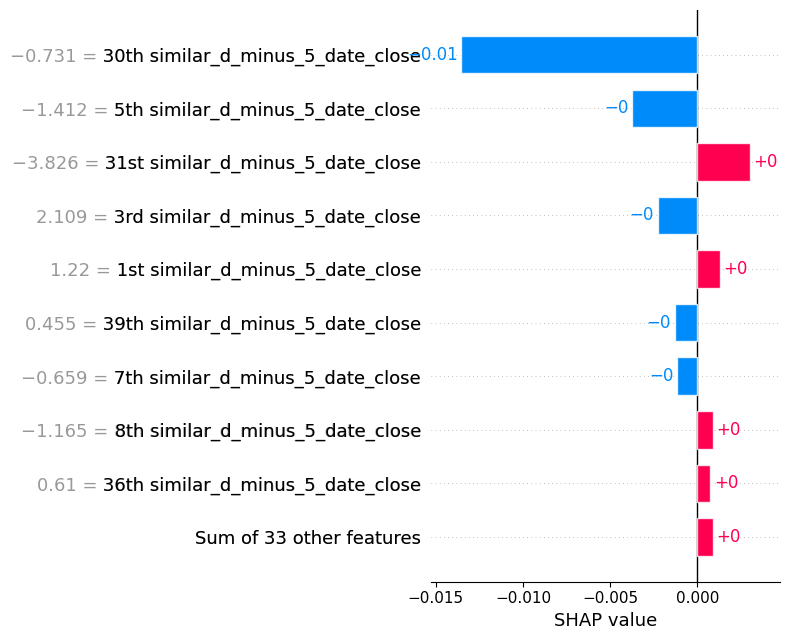


비교 뉴스 2:
카카오뱅크, 일본 S 스미신넷뱅크, 미국 뱅코프 등 세 곳을 비교기업으로 선정한 케이뱅크는 다음달 10~16일 기관 수요예측, 21~22일 일반 청약을 거쳐 다음달 말 상장할 계획이다. ...


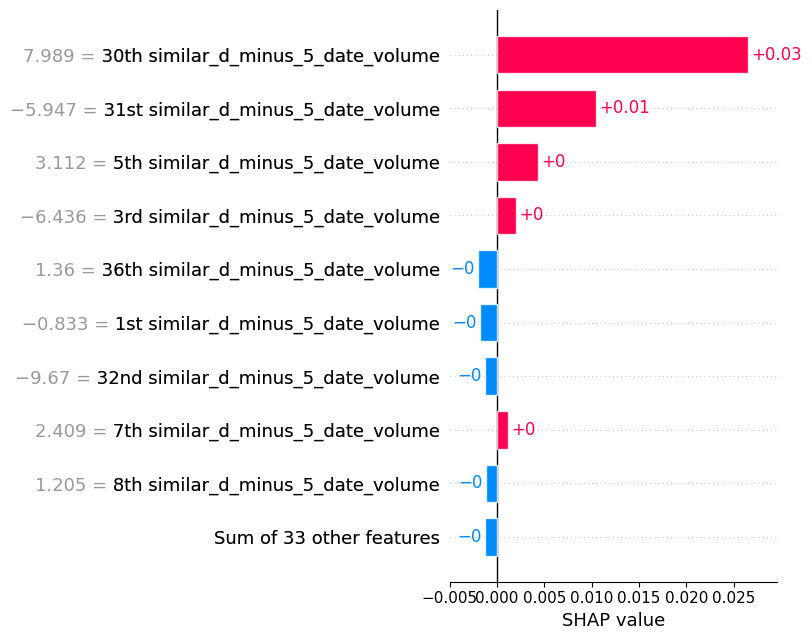


비교 뉴스 3:
최근 CJ대한통운은 신세계 그룹과 물류 협력을 추진하기로 하면서 G마켓과 SSG.com의 스마일 배송 물량은 월 250만건, 새벽 배송·쓱배송 물량은 200만건 수준으로 알려졌으며 신세계 그룹은 이마트 산지 농산물 매입 등도 CJ대한 통운에 위탁하는 방안을 협의 중인 것으로 알려졌다. ...


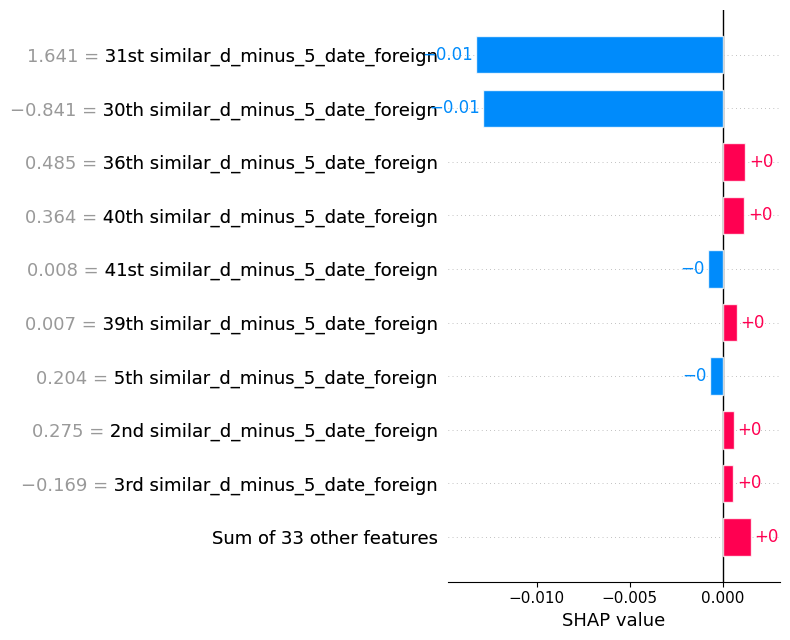

In [17]:
import shap
import matplotlib.pyplot as plt

# 텍스트 임베딩 및 외부변수 준비
text_latents_B = model.encode_text(selected_df['similar_summary'].tolist())
extB_input = (2.0 * extB_tensor[selected_df.index]).to(text_latents_B.device)  # alpha=2.0
dummy_text = torch.zeros((extB_input.shape[0], model.latent_dim)).to(extB_input.device)
inputB = torch.cat([dummy_text, extB_input], dim=1)

# SHAP 입력용 numpy
extB_np = extB_input.cpu().numpy()

# 예측을 위한 wrapper 함수 (extB만 바꿔가며 예측)
# SHAP용 wrapped model 수정 (device 통일 필수!)
def wrapped_ext_model(x_numpy):
    x_tensor = torch.tensor(x_numpy, dtype=torch.float32).to(next(model.parameters()).device)
    dummy_text = torch.zeros((x_tensor.shape[0], model.latent_dim)).to(x_tensor.device)
    concat_input = torch.cat([dummy_text, x_tensor], dim=1)
    with torch.no_grad():
        h = model.news_fc(concat_input)
        out = model.regressor(torch.cat([h, h], dim=1))  # 기준뉴스 동일 가정
        return out.cpu().numpy()

# 변수명 리스트 준비 (header_cols는 이미 위에서 정의된 상태라고 가정)
ext_b = [
    col for col in header_cols
    if col.startswith('similar_d_minus_') or
       col.startswith('similar_d_plus_') or
       col.startswith('similar_D_day_') or
       col in ['similar_fx', 'similar_bond10y', 'similar_base_rate'] or
       col.startswith('similar_topic')
]

# SHAP Explainer 구성 (변수명 추가)
masker = shap.maskers.Independent(extB_np)
explainer = shap.Explainer(wrapped_ext_model, masker, feature_names=ext_b)

# SHAP 값 계산
shap_values = explainer(extB_np, max_evals=512)

# 시각화
for i in range(top_n):
    print(f"\n비교 뉴스 {i+1}:")
    print(selected_df['similar_summary'].iloc[i][:200], '...')
    shap.plots.bar(shap_values[i], show=False)
    plt.tight_layout()
    plt.show()

In [18]:
import numpy as np

# SHAP 값 + 변수명 가져오기 (예: 첫 번째 비교 뉴스 기준)
values = shap_values[0].values
names = shap_values.feature_names

# 절댓값 기준 상위 5개 영향 변수 인덱스
top_indices = np.argsort(np.abs(values))[::-1][:5]

# 문장 생성
print("이 과거 뉴스는 다음 외부 변수들에 의해 유사도가 결정되었습니다:\n")
for idx in top_indices:
    var = names[idx]
    val = values[idx]
    direction = "높일 가능성이 있음" if val > 0 else "낮출 가능성이 있음"
    print(f"- 변수 '{var}' 은(는) 모델의 유사도 예측값을 {abs(val):.4f}만큼 {direction}.")

이 과거 뉴스는 다음 외부 변수들에 의해 유사도가 결정되었습니다:

- 변수 'similar_fx' 은(는) 모델의 유사도 예측값을 0.0136만큼 낮출 가능성이 있음.
- 변수 'similar_d_minus_4_date_close' 은(는) 모델의 유사도 예측값을 0.0037만큼 낮출 가능성이 있음.
- 변수 'similar_bond10y' 은(는) 모델의 유사도 예측값을 0.0030만큼 높일 가능성이 있음.
- 변수 'similar_d_minus_5_date_institution' 은(는) 모델의 유사도 예측값을 0.0023만큼 낮출 가능성이 있음.
- 변수 'similar_d_minus_5_date_volume' 은(는) 모델의 유사도 예측값을 0.0013만큼 높일 가능성이 있음.


In [37]:
!pip install onnxruntime

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 38.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 19.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [51]:
import pandas as pd
import numpy as np
import torch
import onnxruntime as ort
import joblib
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer

# 모델/토크나이저/스케일러 로드
ae_session = ort.InferenceSession('C_onnx/ae_encoder.onnx')
reg_session = ort.InferenceSession('C_onnx/regressor_model.onnx')
model_emb = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')
tokenizer = AutoTokenizer.from_pretrained('C_onnx/tokenizer_dir/')

# 입력 이름
ae_input_name = ae_session.get_inputs()[0].name
reg_input_names = [inp.name for inp in reg_session.get_inputs()]

# 스케일러 불러오기 (딕셔너리 형태)
import os
scaler_dict_a = {}
scaler_dict_b = {}

for file in os.listdir('C_onnx/scalers_grouped'):
    path = f'C_onnx/scalers_grouped/{file}'
    scaler = joblib.load(path)
    if file.startswith('extA'):
        key = file.replace('extA_', '').replace('.pkl', '')
        scaler_dict_a[key] = scaler
    elif file.startswith('extB'):
        key = file.replace('extB_', '').replace('.pkl', '')
        scaler_dict_b[key] = scaler

# 필요한 컬럼 리스트 재생성
extA_cols = sum(ext_a_groups, [])  # flatten
extB_cols = sum(ext_b_groups, [])

# 예측 결과 저장용 리스트
results = []

# 기준 뉴스 ID 리스트 추출
anchor_ids = df['news_id'].drop_duplicates().sample(10, random_state=42).tolist()

for anchor_id in anchor_ids:
    anchor_df = df[df['news_id'] == anchor_id].reset_index(drop=True)
    anchor_row = anchor_df.iloc[0]

    summary_text = anchor_row['summary']
    anchor_emb = model_emb.encode(summary_text, convert_to_numpy=True).reshape(1, -1).astype(np.float32)
    anchor_latent = ae_session.run(['latent'], {ae_input_name: anchor_emb})[0]

    # 외부 변수 스케일링 (기준 뉴스)
    extA_parts = []
    for group in ext_a_groups:
        key = group[0]
        vals = anchor_row[group].values.reshape(1, -1)
        scaled = scaler_dict_a[key].transform(vals)
        extA_parts.append(scaled)
    extA_scaled = np.concatenate(extA_parts, axis=1) * 2.0

    summary_input = np.concatenate([anchor_latent, extA_scaled], axis=1).astype(np.float32)

    scores = []
    for _, row in anchor_df.iterrows():
        similar_text = row['similar_summary']
        similar_emb = model_emb.encode(similar_text, convert_to_numpy=True).reshape(1, -1).astype(np.float32)
        similar_latent = ae_session.run(['latent'], {ae_input_name: similar_emb})[0]

        # 외부 변수 (비교 뉴스)
        extB_parts = []
        for group in ext_b_groups:
            key = group[0]
            vals = row[group].values.reshape(1, -1)
            scaled = scaler_dict_b[key].transform(vals)
            extB_parts.append(scaled)
        extB_scaled = np.concatenate(extB_parts, axis=1) * 2.0

        similar_input = np.concatenate([similar_latent, extB_scaled], axis=1).astype(np.float32)

        # 예측
        pred = reg_session.run(['prediction'], {
            reg_input_names[0]: summary_input,
            reg_input_names[1]: similar_input
        })[0][0][0]

        scores.append((pred, row['similar_summary']))

    # 유사도 기준 정렬
    scores = sorted(scores, key=lambda x: x[0], reverse=True)

    # 결과 출력
    print(f'\n기준 뉴스 [{anchor_id}]:\n{summary_text[:200]}...\n' + '-'*90)
    print('유사 뉴스 랭킹 (예측 유사도 순)\n')

    for i, (pred, text) in enumerate(scores, 1):
        print(f'[{i}] 예측 유사도: {pred:.4f}')
        print(f'    뉴스 요약: {text[:120]}...')
    print('='*90)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/vali


기준 뉴스 [20250228_0026]:
28일 SK증권이 인도네시아 재계 서열 7위 대기업인 마야파다 그룹(Mayapada Group) 투자은행(IB) 업무의 국내 단독 자문사로 선정되었으며 이번 방한은 SK증권 글로벌사업본부가 주관했다....
------------------------------------------------------------------------------------------
유사 뉴스 랭킹 (예측 유사도 순)

[1] 예측 유사도: 0.7638
    뉴스 요약: 미래에셋증권은 지난 2017년 국내 증권사 최초로 인도 자본시장에 진출한 데 이어 6년만에 국내 최초로 현지 증권사 쉐어칸 인수를 완료했다고 28일 밝혔으며 이를 통해 글로벌 비즈니스를 통해 여타 금융사와 차별화된 ...
[2] 예측 유사도: 0.7032
    뉴스 요약: 농기계 전문기업 TYM은 지난 24일과 25일 양일간 필리핀 일로일로(Iloilo) 지역에서 필리핀 공식 파트너사 Fit Corea, 농기계조합이 공동 주관해 현지 딜러와 농민을 대상으로 TY M 로드쇼를 개최해 성...
[3] 예측 유사도: 0.6808
    뉴스 요약: 미래에셋증권 19일 글로벌 금융 전문지인 '유로머니(Euromoney)'가 미래에셋증권을 대한민국 최우수 증권사로 선정했다고 밝히며 올해 인도 쉐어칸(Sharekhan) 증권사 인수가 마무리되면 글로벌 사업에서 연간...
[4] 예측 유사도: 0.6640
    뉴스 요약: 두바이는 인도와 지리적으로 가깝고 전체 인구 중 인도인이 약 40%를 차지하고 있어, 현지 인도인들의 투자 수요가 높은 지역이며, 미래에셋증권이 인도 현지 증권사 쉐어칸을 인수하며, 향후 인도 현지에서 미래에셋그룹의...
[5] 예측 유사도: 0.6627
    뉴스 요약: 삼부토건은 페르디난드 마르코스 주니어 필리핀 대통령의 공약 사업인 '4PH'의 주택사업 50만호 가운데 면적 27m2 ~ 28m2 규모의 5만호를 GHCI와 공급 관련 업무협약(MOU)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/vali


기준 뉴스 [20241115_0029]:
15일 금융감독 금융감독원 전자공시시스템에 따르면 오후 5시 50분께 삼성전자는 자기주식 취득 계획을 공시하였으며 취득 규모는 10조원이며 향후 1년간 분할 매입하겠다고 밝혔다....
------------------------------------------------------------------------------------------
유사 뉴스 랭킹 (예측 유사도 순)

[1] 예측 유사도: 0.7872
    뉴스 요약: 3일 금융감독원 전자공시시스템에 따르면 전일 한화에어로스페이스는 주주가치 및 경영 효율성 제고를 위해 사업 특성을 고려한 인적분할을 검토하고 있다고 공시했으며 오는 5일 개최 예정인 이사회에 이를 상정할 것으로 알려...
[2] 예측 유사도: 0.7859
    뉴스 요약: 미래에셋증권은 자사주 1000만 주를 장내에서 매입해 소각하겠다고 7일 공시했으며 앞으로 3개월 동안 장내에서 주식을 매입할 예정이기 때문에 매입 당시 주가에 따라 회사가 실제 투입하는 금액은 달라질 수 있다고 설명...
[3] 예측 유사도: 0.7802
    뉴스 요약: 25일 금융감독원 전자공시시스템에 따르면 미래에셋증권이 주주가치 제고를 위해 약 700억원 규모의 자사주를 매입할 예정이라고 공시했으며 내달 22일 이사회를 통해 자기주식 소각 및 배당안 결의를 계획하고 있다고 밝혔...
[4] 예측 유사도: 0.7707
    뉴스 요약: HD한국조선해양이 자사가 소유한 HD현대중공업 주식 266만3193주를 매각하기로 했다고 16일 공시했으며 이번 거래는 오는 17일 장 개시 전 시간외 대량매매(블록딜) 방식으로 진행될 예정이다....
[5] 예측 유사도: 0.5891
    뉴스 요약: 외국인이 삼성전자 9시30분까지 807억원어치를 순매수하고 있으며 두 번째로 많이 순매수하는 SK하이닉스의 순매수 규모는 333억원이다. ...

기준 뉴스 [20250428_0018]:
한화에어로스페이스(012450) 와 현

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/vali


기준 뉴스 [20250108_0099]:
한화오션은 장 마감 후 6292억원 규모의 선박용 엔진 공급 계약을 체결했다고 공시했으며 계약 기간은 오는 1월 7일부터 2028년 11월 8일까지로 약 3년 10개월이다....
------------------------------------------------------------------------------------------
유사 뉴스 랭킹 (예측 유사도 순)

[1] 예측 유사도: 0.7613
    뉴스 요약: HMM의 잔여 영구채는 2024년 1억7200만주, 2025년 1억4400만주로 주식으로 전환시 발행주식수는 약 10억 2500만주로 단기적으로 실적 상향 및 주가 상승이 이어질 것으로 전망된다.   ...
[2] 예측 유사도: 0.7435
    뉴스 요약: 현대로템은 이집트터널청으로부터 이집트 알렉산드리아 트램 공급 사업 낙찰통지서를 지난 24일 수령했다고 공시했으며, 계약기간은 계약발효일로부터 총 153개월(차량+2년 유지보수 57개월·유지보수 96개월 )로 예상되며...
[3] 예측 유사도: 0.7089
    뉴스 요약: 에쓰씨엔지니어링은 애경케미칼과 910억원 규모 공사를 수주했다고 13일 공시했으며 계약기간은 오는 2025년 12월 31일까지다....
[4] 예측 유사도: 0.7040
    뉴스 요약: HD현대미포가 45K LPGC(액화석유가스 운반선) 2척 수주 계약을 체결했다고 7일 공시했으며 계약기간은 오는 2027년 4월 30일까지이다....
[5] 예측 유사도: 0.6928
    뉴스 요약: 삼성바이오로직스가 12일 공시를 통해 글로벌 제약사 MSD 스위스 법인과 927억원 규모의 위탁생산 계약을 맺었다고 밝혔으며 계약기간은 오는 2032년 12월31일까지로 양사 합의에 따라 변동될 수 있다....

기준 뉴스 [20250327_0155]:
한화에어로스페이스의 대규모 유상증자 결정에 한화그룹주가 동반 급락한 가운데, 지난 2021년 한화시스템 유상증자 때와 상황이 유사

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/vali